# [AWS Secret Engine](https://developer.hashicorp.com/vault/docs/secrets/aws)

## Permissions granted

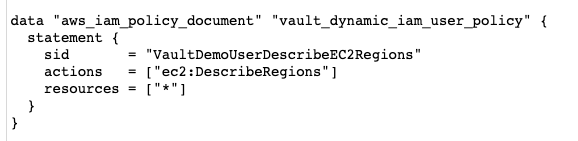


In [ ]:
%env  WORKDIR=/tmp/vault

In [ ]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

In [ ]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.0buy0tW2QcQARwJGQsEyg8Ad
%env VAULT_CACERT=/tmp/vault/vault.ca

In [ ]:
%%bash
vault write aws/config/lease lease=30m lease_max=30m

## Test Lease Request

In [ ]:
%%bash
vault read aws/creds/vault-demo-iam-user
echo "-----"
vault read aws/creds/vault-demo-federation-token
echo "-----"
vault read aws/creds/vault-demo-assumed-role

## Rotate Root credentials

In [ ]:
%%bash
vault write -f aws/config/rotate-root

## Demo Part

In [ ]:
%%bash
## Requesting using CLI
sleep 10
vault read aws/creds/vault-demo-iam-user

In [ ]:
%%bash
# Using CURL

curl -k --header "X-Vault-Token: $VAULT_TOKEN" \
    --silent --request GET \
    $VAULT_ADDR/v1/aws/creds/vault-demo-iam-user | jq .data -r
    
echo "---------New request == different credentials ----------"

curl -k --header "X-Vault-Token: $VAULT_TOKEN" \
    --silent --request GET \
    $VAULT_ADDR/v1/aws/creds/vault-demo-iam-user | jq . -r > $WORKDIR/temp_aws_creds.json

echo "access_key: $(cat $WORKDIR/temp_aws_creds.json | jq -r .data.access_key)"
echo "secret_key: $(cat $WORKDIR/temp_aws_creds.json | jq -r .data.secret_key)"

In [ ]:
%%bash
## Active leases for a given role
vault list sys/leases/lookup/aws/creds/vault-demo-iam-user

In [ ]:
%%bash
export AWS_ACCESS_KEY_ID=$(cat $WORKDIR/temp_aws_creds.json | jq -r .data.access_key)
export AWS_SECRET_ACCESS_KEY=$(cat $WORKDIR/temp_aws_creds.json | jq -r .data.secret_key)
aws ec2 describe-regions --region us-east-1

In [ ]:
%%bash
#This will fail as that permissions has not been granted
export AWS_ACCESS_KEY_ID=$(cat $WORKDIR/temp_aws_creds.json | jq -r .data.access_key)
export AWS_SECRET_ACCESS_KEY=$(cat $WORKDIR/temp_aws_creds.json | jq -r .data.secret_key)
aws ec2 describe-addresses  --region us-east-1

## Revoke leases

In [ ]:
%%bash
## Active leases for a given role
vault list -format=json sys/leases/lookup/aws/creds/vault-demo-iam-user | jq -r .[]

In [ ]:
%%bash
## Revoke a single lease, in this case the first one from the list
vault lease revoke aws/creds/vault-demo-iam-user/\
$(vault list -format=json sys/leases/lookup/aws/creds/vault-demo-iam-user | jq -r .[0])

In [ ]:
%%bash
## To obtain details for one of the leases I can use the lookup endpoint. 
vault lease lookup aws/creds/vault-demo-iam-user/\
$(vault list -format=json sys/leases/lookup/aws/creds/vault-demo-iam-user | jq -r .[0])

In [ ]:
%%bash
## Active leases for a given role
vault list -format=json sys/leases/lookup/aws/creds/vault-demo-iam-user | jq -r .[]

In [ ]:
%%bash
## Revoke all leases for a given role
vault lease revoke -prefix aws/creds/vault-demo-iam-user

In [ ]:
%%bash
## Active leases for a given role (takes a couple of seconds to clean)
sleep 3
vault list -format=json sys/leases/lookup/aws/creds/vault-demo-iam-user | jq -r .[]

## Unrelated OIDC config for GCP